## (1) data preprocessing
#### (1.0) user settings
* `path_project` : project folder containing data in BIDS format
* `path_slicetiming_json`: json file containing SliceTiming field   

In [ ]:
path_project = '/home/kamil/Desktop/Neuroscience/Projects/WD_fasting/'
path_slicetiming_json = '/home/kamil/Desktop/Neuroscience/Projects/WD_fasting/code/WD_fasting_slicetiming.json'

#### (1.1) append missing slice timing field to funcional json files within BIDS structure 

In [41]:
from kbtools import append_json
import os

json_list = []
for path, subdirs, files in os.walk(path_project):
    for name in files:
        if 'bold.json' in name:
            json_list.append(os.path.join(path, name))

for file in json_list:
    append_json(file, path_slicetiming_json)    

#### (1.2) run standard preprocessing using fmriprep

In [29]:
import os

path_project_derivatives = path_project + '/derivatives'
path_project_derivatives_interm = path_project_derivatives + '/intermediate' 

if not os.path.exists(path_project_derivatives_interm):
    !mkdir $path_project_derivatives_interm

#--- look for .bash environmental variable containing fsl license
fsl_test = !echo ${FS_LICENSE:-False}    
  
#--- run preprocessing 
if fsl_test[0] == 'False':
    fs_license_path = input('FSL license not found! Provide full path to fsl license')
    !sudo fmriprep-docker $path_project $path_project_derivatives participant \
    --participant-label wd01 --longitudinal --use-aroma -w $path_project_derivatives_interm \
    --fs-license $fs_license_path
else:
    !sudo fmriprep-docker $path_project $path_project_derivatives participant \
    --participant-label wd01 --longitudinal --use-aroma -w $path_project_derivatives_interm

## (2) functional connectivity estimation
#### (2.0) user settings
* `path_project_deriv` : project derivatives folder containing preprocessed functional data
* `path_analysis` : project analysis data (timeseries, connectivity matrixes, etc.)
* `sub_list` : list of subjects 

In [130]:
import os
from os.path import join, exists

sub_list = ['sub-wd01']
path_project_deriv = '/home/kamil/Desktop/Neuroscience/Projects/WD_fasting/derivatives/'
path_analysis = join(path_project_deriv,'connectivity_analysis')

if not exists(path_analysis):
    os.mkdir(path_analysis)

In [218]:
def find_files(expression, path_sub):
    return sorted([ join(folder,file) for folder in [ join(path_sub,f,'func') 
                                      for f in listdir(path_sub) if 'ses' in f ] 
                                      for file in listdir(folder) if expression in file ])
def draw_timeseries(timeseries, roi1, roi2):
    %matplotlib inline
    import matplotlib.pyplot as plt
    from scipy.stats.stats import pearsonr  

    #--- calculate correlation
    r = pearsonr(timeseries[0][:,roi1], timeseries[0][:,roi2])[0].round(2)
    r = "{0:.2f}".format(r)

    #--- plotting
    fig = plt.figure(figsize=(15,3))
    plt.plot(range(0, 1200, 2),timeseries[0][:,roi1], 'r', label=f'roi {str(roi1)}')
    plt.plot(range(0, 1200, 2),timeseries[0][:,roi2], 'b', label=f'roi {str(roi2)}')
    plt.xlim([0,1200])
    plt.legend(bbox_to_anchor=(1.1, 1), fancybox=True, shadow=True)
    plt.annotate(f'r = {r}', xy=(0.01,0.9), xycoords='axes fraction', size=15)
    plt.xlabel('time [s]')
    plt.ylabel('normalized BOLD')
    plt.show()

#### (2.1)  confound processing
- finding fmriprep confound files
- extracting confound regressors of interest
- saving as a new file (filenames stored in `path_conf_clean` list)

In [104]:
from os.path import join, split
from os import listdir
import pandas as pd
import os

#--- subject derivatives folder (for more than one subject use loop)
path_sub = join(path_project_deriv,'fmriprep',sub_list[0])

#--- detect confounds
path_conf = find_files('confounds.tsv', path_sub)
path_conf_clean = [ path.replace('confounds','confounds_clean') for path in path_conf ]

#--- confounds processing
for file_conf, file_conf_clean in zip(path_conf, path_conf_clean):
    confounds = pd.read_csv(file_conf, delimiter = '\t')
    confounds = confounds.filter(regex='CSF|WhiteMatter|CompCor|X|Y|Z')
    confounds.to_csv(file_conf_clean, sep=',', index=False)

#### (2.2) loading atlas & extracting timeseries
- loading brain parcellation of interest (variable `atlas`)
- creating NiftiSpheresMasker object with all atlas settings like:
    - amount of signal smoothing
    - sphere radius
    - detrend
    - standarization
    - low-pass and high-pass filters
- exctracting and calculating timeseries with confounds regression

In [ ]:
import numpy as np
import pandas as pd
import pickle
from nilearn import datasets
from nilearn.input_data import NiftiMapsMasker, NiftiSpheresMasker
from os.path import join

#--- subject derivatives folder (for more than one subject use loop)
path_sub = join(path_project_deriv,'fmriprep',sub_list[0])

#--- find confounds and functional .nii files
path_conf = find_files('confounds_clean.tsv', path_sub)
path_rest = find_files('AROMAnonaggr_preproc.nii.gz', path_sub)

#--- load atlas coordinates
atlas = datasets.fetch_coords_power_2011()
atlas_coords = np.vstack((atlas.rois['x'], atlas.rois['y'], atlas.rois['z'])).T
atlas_spheres = NiftiSpheresMasker(
    seeds = atlas_coords, # spheres centres 
    radius = 5,           # sphere radius
    smoothing_fwhm = 6,   # amount of signal smoothing
    detrend = True, 
    standardize = True,
    low_pass = 0.08, 
    high_pass = 0.009,
    t_r = 2,
    verbose = 0)

timeseries = []
for scan, nii_file in enumerate(path_rest):
    #--- extract timeseries
    #print(f'[script] Extracting timeseries for scan {scan}')
    #print(f'[script] Image file: {nii_file[-100:]}')
    #print(f'[script] Confounds file: {path_conf[scan][-51:]}')
    timeseries.append(atlas_spheres.fit_transform(nii_file, confounds=path_conf[scan]))
    
#--- save timeseries data along with metadata
confounds_head = pd.read_csv(path_conf[0], delimiter = ',').iloc[:5] # first row of exemplary confound file
with open(join(path_analysis, 'timeseries.pkl'), 'wb') as f: 
    pickle.dump([timeseries, atlas_spheres, confounds_head], f)

Show example timeseries between `roi1` and `roi2` (for first scanning session)

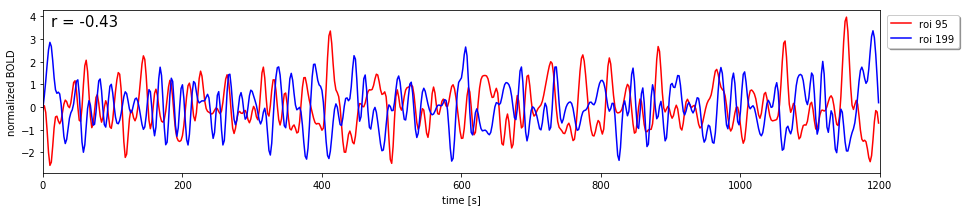

In [242]:
#--- select pair of rois
roi1 = 95
roi2 = 199

#--- plot example timeseries
draw_timeseries(timeseries, roi1, roi2)

#### (2.3) calculating static FC

In [145]:
from nilearn.connectome import ConnectivityMeasure

#--- calculate static FC from clean ROI timeseries
connectivity = ConnectivityMeasure(kind='correlation')
sFC = connectivity.fit_transform(timeseries)

Show example connectivity matrix (for first scanning session)

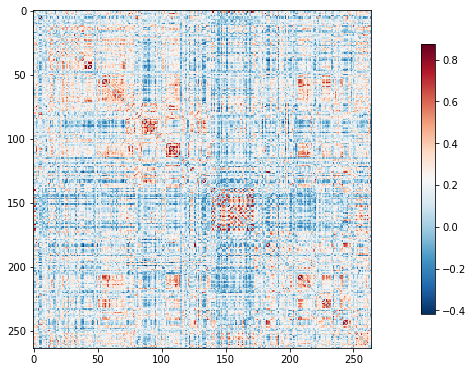

In [243]:
from nilearn.plotting import plot_matrix

plot_matrix(sFC[0])

#### (2.4) calculating dynamic FC